In [219]:
"""
@date: 28rd May 2022
@author: Anna Ketteler
"""
import sys
import os
sys.path.append(os.path.abspath('GENIE3'))
sys.path.append(os.path.abspath(''))
from GENIE3_python import GENIE3 as gn
import seaborn as sns
import numpy as np
import pandas as pd
import csv

cancer_type = 'TCGA-BLCA'
dateStart = '2022-06-12-15-24-50'
confounder_classes = ['asian', 'african', 'white']
n = 10
m = 2
cutoff = 50

# TODO: get all this from a meta data file printed by data_partitioning.py?

cwd = os.getcwd()
results_dir = os.path.join(cwd, 'results')
timestamp_dir = os.path.join(results_dir, str(dateStart))
conf_results_dir = os.path.join(timestamp_dir, str(cancer_type)+'_conf_results')
rnd_results_dir = os.path.join(timestamp_dir, str(cancer_type)+'_rnd_results')

In [220]:
rnd_res = [] # list of tuples of arrays
for k in range(n):
    partition_res = [] # tuple of arrays (each array corresponds to a block)
    for block_class in confounder_classes:
        prefix = os.path.join(rnd_results_dir, 'ranking_iter_'+str(k)+'_rndBlock_'+str(block_class)+'.txt')
        block_res = np.genfromtxt(fname=prefix, delimiter="\t", dtype=str) # array
        partition_res.append(block_res[:, :2])
    rnd_res.append(tuple(partition_res))
#print(len(rnd_res)) # equals number of generated random partitions

In [221]:
conf_res = []
for k in range(m):
    partition_res = []
    for block_class in confounder_classes:
        prefix = os.path.join(conf_results_dir, 'ranking_iter_'+str(k)+'_confBlock_'+str(block_class)+'.txt')
        block_res = np.genfromtxt(fname=prefix, delimiter="\t", dtype=str)
        partition_res.append(block_res[:, :2])
    conf_res.append(tuple(partition_res))

In [222]:
def countOverlapping(l, k):
    sets = []
    for block in l:
        block_set = set([tuple((t[0], t[1])) for t in block[:k]])
        sets.append(block_set)
    jaccard_index = len(set.intersection(*sets))/len(set.union(*sets))
    return jaccard_index

In [223]:
ks = np.array(range(5, cutoff, 5))
partitions = ['rnd_pt_'+str(i) for i in range(n)]
df_rnd = pd.DataFrame(columns=ks, index=partitions)
i = 0

for partition_res in rnd_res:
    partition_res = [block_res[:cutoff] for block_res in partition_res]
    jacc_indices = []
    for k in range(5, cutoff, 5):
        jacc_indices.append(countOverlapping(partition_res, k))
    jacc_indices = np.array(jacc_indices)
    if i == 0:
        df_rnd.loc[partitions[i]] = jacc_indices
    else:
        df_rnd.loc[partitions[i]] = jacc_indices 
    i = i + 1
    
df_rnd

,5,10,15,20,25,30,35,40,45
rnd_pt_0,0.0,0.0,0.0,0.019231,0.031746,0.042857,0.0375,0.032258,0.04
rnd_pt_1,0.0,0.0,0.028571,0.021277,0.016949,0.014925,0.012987,0.034483,0.041667
rnd_pt_2,0.0,0.0,0.052632,0.040816,0.050847,0.042254,0.059524,0.076087,0.068627
rnd_pt_3,0.0,0.038462,0.026316,0.020833,0.016393,0.013699,0.035714,0.042105,0.057692
rnd_pt_4,0.0,0.0,0.0,0.040816,0.067797,0.068493,0.059524,0.076087,0.079208
rnd_pt_5,0.0,0.0,0.0,0.021739,0.017241,0.028986,0.025641,0.033708,0.03125
rnd_pt_6,0.0,0.0,0.0,0.0,0.0,0.0,0.011905,0.021277,0.04
rnd_pt_7,0.0,0.037037,0.02439,0.018868,0.016949,0.028169,0.037037,0.043011,0.06
rnd_pt_8,0.0,0.0,0.0,0.02,0.016129,0.013158,0.035714,0.044444,0.050505
rnd_pt_9,0.0,0.0,0.0,0.020408,0.032787,0.042857,0.0625,0.054348,0.048077


In [224]:
ks = np.array(range(5, cutoff, 5))
partitions = ['conf_pt_'+str(i) for i in range(m)]
df_conf = pd.DataFrame(columns=ks, index=partitions)
i = 0
for partition_res in conf_res:
    partition_res = [block_res[:cutoff] for block_res in partition_res]
    jacc_indices = []
    for k in range(5, cutoff, 5):
        jacc_indices.append(countOverlapping(partition_res, k))
    jacc_indices = np.array(jacc_indices)
    if i == 0:
        df_conf.loc[partitions[i]] = jacc_indices
    else:
        df_conf.loc[partitions[i]] = jacc_indices 
    i = i + 1
#df_conf.loc['k'] = ks

df_conf

,5,10,15,20,25,30,35,40,45
conf_pt_0,0.0,0.0,0.0,0.0,0.0,0.012987,0.011364,0.010204,0.009259
conf_pt_1,0.0,0.0,0.0,0.018519,0.031746,0.041096,0.035714,0.043011,0.048077


<AxesSubplot:>

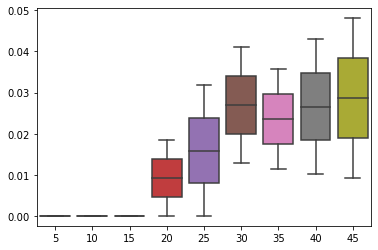

In [225]:
# compare pairwise similarities of the results per k
sns.boxplot(data=df_conf)

<AxesSubplot:>

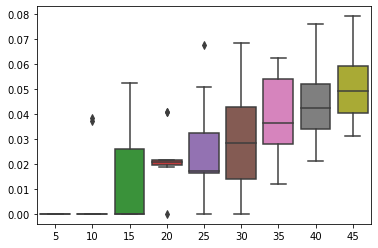

In [226]:
sns.boxplot(data=df_rnd)

<AxesSubplot:>

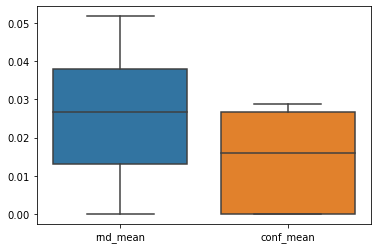

In [227]:
df = pd.DataFrame()
df['rnd_mean'] = df_rnd.mean(axis=0)
df['conf_mean'] = df_conf.mean(axis=0)

sns.boxplot(data=df)


In [228]:
# TODO of course we can't see anything from this, because n and m are too small and
# not all genes are taken into account
def oc(df, steps):
    ks = np.array(range(5, cutoff, 5))
    for col in df:
        df[col]= df[col]/np.log(int(col))

    oc_figures_per_row = (1/steps)*np.array([df.iloc[i,:].sum() for i in range(df.shape[0])])
    mean_penalized_oc = (1/len(oc_figures_per_row))*oc_figures_per_row
    print(mean_penalized_oc) # per partition

In [229]:
# compute figures (1/|steps|) * sum(oc(k)/log(k)) per row with k is col and oc(k) is value
steps = (cutoff/5)-1
oc(df_rnd.copy(), steps)
oc(df_conf.copy(), steps)

[0.00065203 0.00056948 0.0012964  0.00087901 0.00125556 0.00050771
 0.00021805 0.00091973 0.00056574 0.00082823]
[0.00067851 0.00347007]
